In [1]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance
from prettytable import PrettyTable

warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('heart.csv')
df.head()

,Age,Sex,ChestPainType,RestingBP,Cholesterol,FastingBS,RestingECG,MaxHR,ExerciseAngina,Oldpeak,ST_Slope,HeartDisease
0,40,M,ATA,140,289,0,Normal,172,N,0.0,Up,0
1,49,F,NAP,160,180,0,Normal,156,N,1.0,Flat,1
2,37,M,ATA,130,283,0,ST,98,N,0.0,Up,0
3,48,F,ASY,138,214,0,Normal,108,Y,1.5,Flat,1
4,54,M,NAP,150,195,0,Normal,122,N,0.0,Up,0


In [3]:
print(df.shape)
df.describe()

(918, 12)


,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,HeartDisease
count,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000,918.000000
mean,53.510893,132.396514,198.799564,0.233115,136.809368,0.887364,0.553377
std,9.432617,18.514154,109.384145,0.423046,25.460334,1.066570,0.497414
min,28.000000,0.000000,0.000000,0.000000,60.000000,-2.600000,0.000000
25%,47.000000,120.000000,173.250000,0.000000,120.000000,0.000000,0.000000
50%,54.000000,130.000000,223.000000,0.000000,138.000000,0.600000,1.000000
75%,60.000000,140.000000,267.000000,0.000000,156.000000,1.500000,1.000000
max,77.000000,200.000000,603.000000,1.000000,202.000000,6.200000,1.000000


In [4]:
df.isnull().sum()

Age               0
Sex               0
ChestPainType     0
RestingBP         0
Cholesterol       0
FastingBS         0
RestingECG        0
MaxHR             0
ExerciseAngina    0
Oldpeak           0
ST_Slope          0
HeartDisease      0
dtype: int64

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 918 entries, 0 to 917
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Age             918 non-null    int64  
 1   Sex             918 non-null    object 
 2   ChestPainType   918 non-null    object 
 3   RestingBP       918 non-null    int64  
 4   Cholesterol     918 non-null    int64  
 5   FastingBS       918 non-null    int64  
 6   RestingECG      918 non-null    object 
 7   MaxHR           918 non-null    int64  
 8   ExerciseAngina  918 non-null    object 
 9   Oldpeak         918 non-null    float64
 10  ST_Slope        918 non-null    object 
 11  HeartDisease    918 non-null    int64  
dtypes: float64(1), int64(6), object(5)
memory usage: 86.2+ KB


In [6]:
df_v = df.copy()
df_v['HeartDisease'] = df_v['HeartDisease'].map({1:'HeartDisease', 0:'No HeartDisease'})
df_v['Sex'] = df_v['Sex'].map({'M':'Male','F':'Female'})
fig1 = px.sunburst(df_v, path=['Sex', 'HeartDisease'], color='HeartDisease', color_discrete_map={'(?)':'black', 'HeartDisease':'Red', 'No HeartDisease':'Green'},
                  title='Heart disease - Gender', width=400, height=400)
fig1.update_layout(margin=dict(l=10, r=10, t=40, b=10))
fig1.show()

As per this dataset, it seems to be men are more likely to have a heart disease

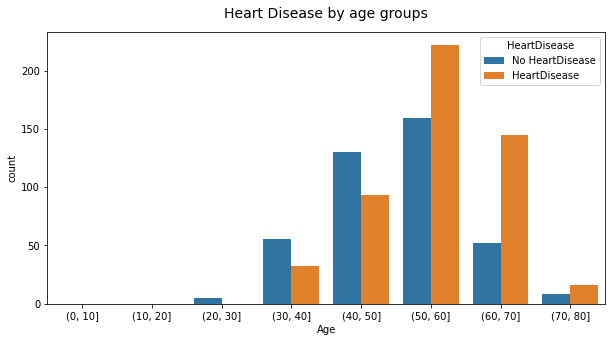

In [7]:
fig2 = plt.figure(figsize=(10,5))
fig2 = sns.countplot(x=pd.cut(df_v['Age'], bins=[x for x in range(0,90,10)]), hue=df_v['HeartDisease'])
fig2.set_title('Heart Disease by age groups', fontdict={'fontsize':14}, pad=14)
plt.show()

Age 50 and older auduls more likely to have a heart disease

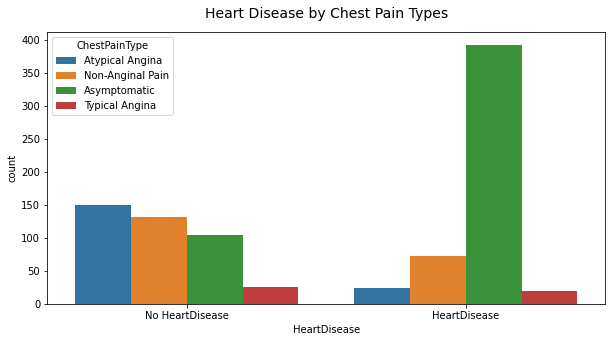

In [8]:
df_v['ChestPainType'] = df_v['ChestPainType'].map({'TA':'Typical Angina', 'ATA':'Atypical Angina', 'NAP':'Non-Anginal Pain', 'ASY':'Asymptomatic'})
fig3 = plt.figure(figsize=(10,5))
fig3 = sns.countplot(x=df_v['HeartDisease'], hue=df_v['ChestPainType'])
fig3.set_title('Heart Disease by Chest Pain Types', fontdict={'fontsize':14}, pad=14)
plt.show()

Asymptomatic chest pain is most common among patients with heart disease

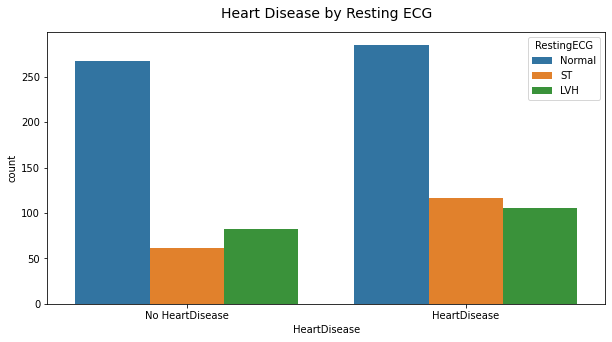

In [9]:
fig4 = plt.figure(figsize=(10,5))
fig4 = sns.countplot(x=df_v['HeartDisease'], hue=df_v['RestingECG'])
fig4.set_title('Heart Disease by Resting ECG', fontdict={'fontsize':14}, pad=14)
plt.show()

No significant difference in Resting ECG among two groups of patients with or without heart disease

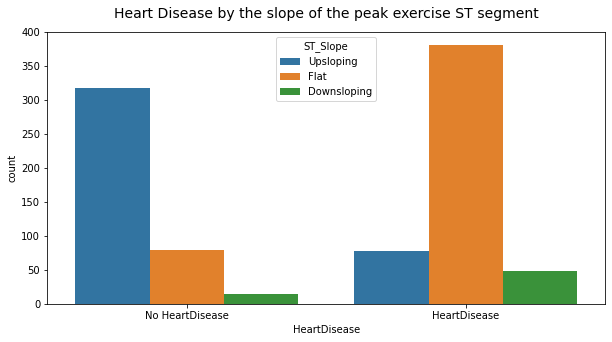

In [10]:
df_v['ST_Slope'] = df_v['ST_Slope'].map({'Up':'Upsloping', 'Flat':'Flat', 'Down':'Downsloping'})
fig5 = plt.figure(figsize=(10,5))
fig5 = sns.countplot(x=df_v['HeartDisease'], hue=df_v['ST_Slope'])
fig5.set_title('Heart Disease by the slope of the peak exercise ST segment', fontdict={'fontsize':14}, pad=14)
plt.show()

Flat is the most common type of ST segment among patients with heart disease

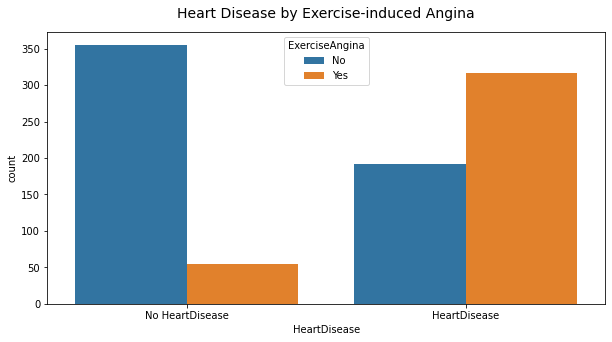

In [11]:
df_v['ExerciseAngina'] = df_v['ExerciseAngina'].map({'Y':'Yes', 'N':'No'})
fig6 = plt.figure(figsize=(10,5))
fig6 = sns.countplot(x=df_v['HeartDisease'], hue=df_v['ExerciseAngina'])
fig6.set_title('Heart Disease by Exercise-induced Angina', fontdict={'fontsize':14}, pad=14) 
plt.show()

Exercise-induced Angina is most common among heart disease patients

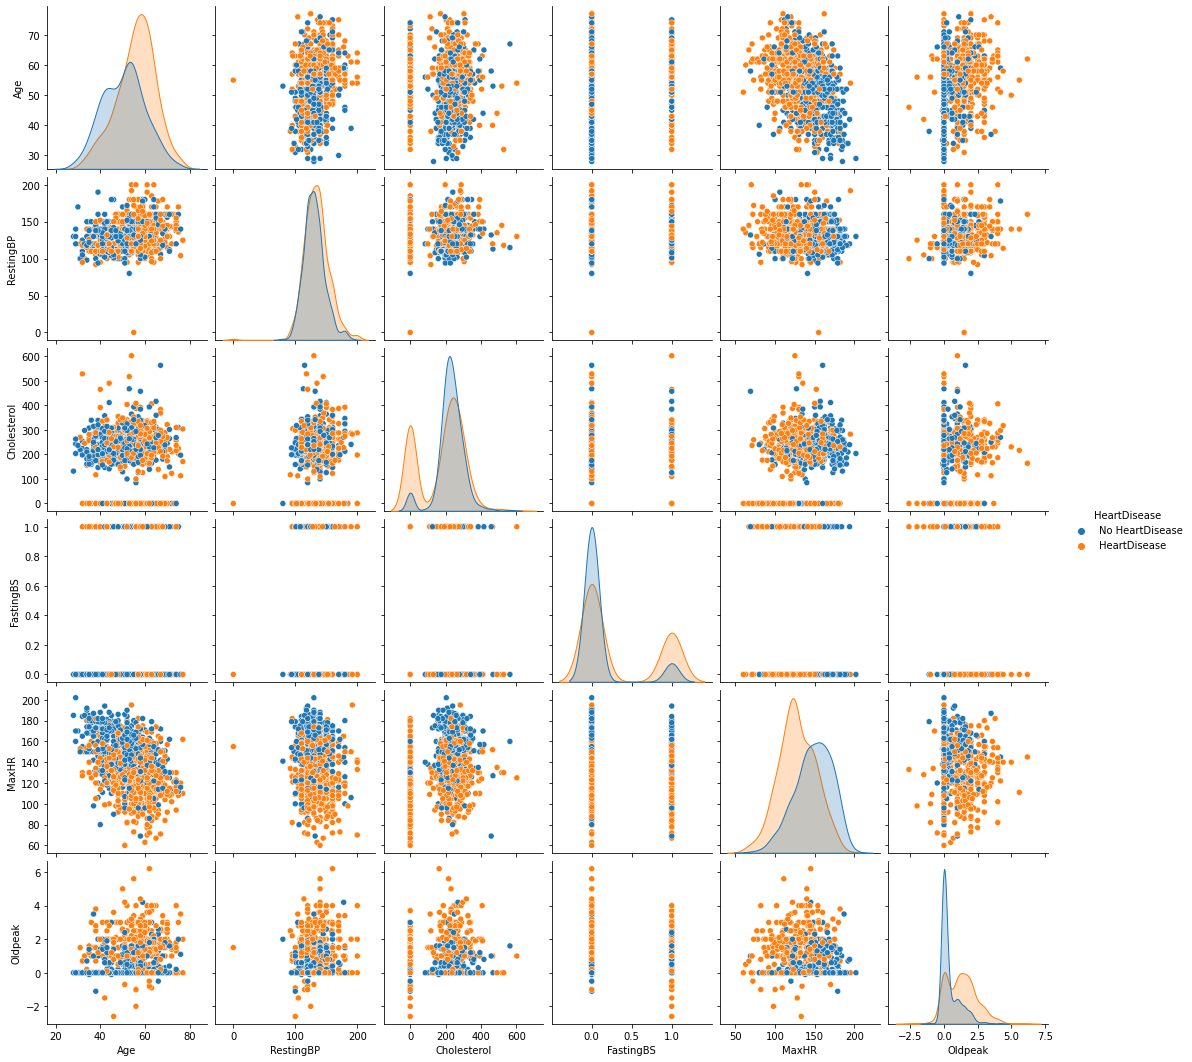

In [12]:
fig7 = sns.pairplot(df_v, hue='HeartDisease')
plt.show()

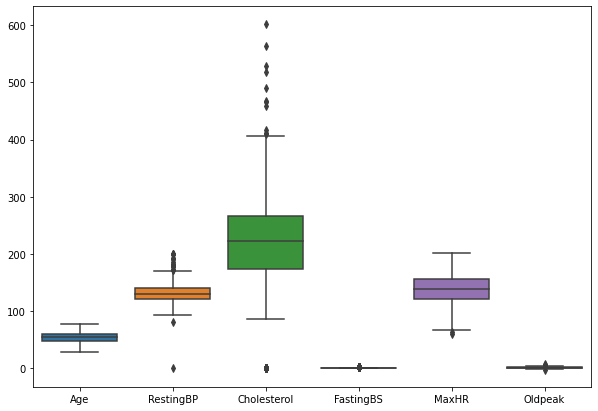

In [13]:
fig8 = plt.figure(figsize=(10,7))
fig8 = sns.boxplot(data=df_v)
plt.show()

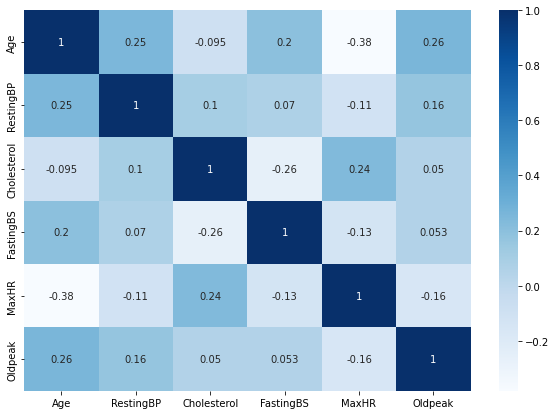

In [14]:
fig9 = plt.figure(figsize=(10,7))
fig9 = sns.heatmap(df_v.corr(), annot=True, cmap='Blues')
plt.show()

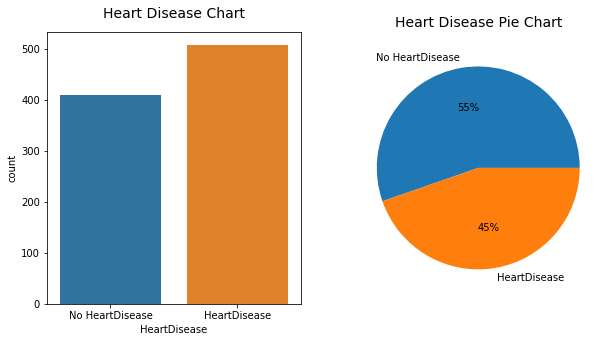

In [15]:
fig10 = plt.figure(figsize=(10,5))
gs = fig10.add_gridspec(1, 2)
ax0 = plt.subplot(gs[0, 0])
ax1 = plt.subplot(gs[0, 1])
fig10 = sns.countplot(x=df_v['HeartDisease'], ax=ax0)
fig10 = plt.pie(df_v['HeartDisease'].value_counts(), labels =['No HeartDisease','HeartDisease'], autopct='%.0f%%')
ax0.set_title('Heart Disease Chart', fontdict={'fontsize':14}, pad=14)
ax1.set_title('Heart Disease Pie Chart', fontdict={'fontsize':14}, pad=14)
plt.show()

Target variable is balanced

In [16]:
X = df.drop(columns=['HeartDisease'])
y = df['HeartDisease']
print(X.shape)
print(y.shape)

(918, 11)
(918,)


In [17]:
X = pd.get_dummies(X, columns=['Sex', 'ChestPainType', 'RestingECG', 'ExerciseAngina', 'ST_Slope'])
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40,140,289,0,172,0.0,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,49,160,180,0,156,1.0,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,37,130,283,0,98,0.0,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,48,138,214,0,108,1.5,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,54,150,195,0,122,0.0,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [18]:
ss = StandardScaler()
X[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'Oldpeak', 'MaxHR']] = pd.DataFrame(ss.fit_transform(X[['Age', 'RestingBP', 'Cholesterol', 'FastingBS', 'Oldpeak', 'MaxHR']]))
X.head()

,Age,RestingBP,Cholesterol,FastingBS,MaxHR,Oldpeak,Sex_F,Sex_M,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ExerciseAngina_N,ExerciseAngina_Y,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,-1.433140,0.410909,0.825070,-0.551341,1.382928,-0.832432,0,1,0,1,0,0,0,1,0,1,0,0,0,1
1,-0.478484,1.491752,-0.171961,-0.551341,0.754157,0.105664,1,0,0,0,1,0,0,1,0,1,0,0,1,0
2,-1.751359,-0.129513,0.770188,-0.551341,-1.525138,-0.832432,0,1,0,1,0,0,0,0,1,1,0,0,0,1
3,-0.584556,0.302825,0.139040,-0.551341,-1.132156,0.574711,1,0,1,0,0,0,0,1,0,0,1,0,1,0
4,0.051881,0.951331,-0.034755,-0.551341,-0.581981,-0.832432,0,1,0,0,1,0,0,1,0,1,0,0,0,1


In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(642, 20) (642,)
(276, 20) (276,)


In [20]:
model_table = PrettyTable()
model_table.field_names = ['Model', 'Set', 'Accuracy Score', 'Precision Score', 'Recall Score', 'F1 Score', 'ROC-AUC Score', 'Log-loss Score']

models = [LogisticRegression(random_state=42),
          DecisionTreeClassifier(criterion='gini', random_state=42),
          RandomForestClassifier(n_estimators=100, max_features=None, random_state=42),
          SVC(kernel='rbf', random_state=42),
          SGDClassifier(max_iter=1000, random_state=42),
          GradientBoostingClassifier(n_estimators=100, max_features=None, random_state=42)]

for model in models:
    model.fit(X_train, y_train)
    y_pred_tr = model.predict(X_train)
    acc_score = accuracy_score(y_train, y_pred_tr)
    precision = precision_score(y_train, y_pred_tr)
    recall = recall_score(y_train, y_pred_tr)
    f1 = f1_score(y_train, y_pred_tr)
    roc_auc = roc_auc_score(y_train, y_pred_tr)
    lg_loss = log_loss(y_train, y_pred_tr)
    model_table.add_row([type(model).__name__, 'Training', format(acc_score, '.2f'), format(precision, '.2f'), format(recall, '.2f'), format(f1, '.2f'), format(roc_auc, '.2f'), format(lg_loss, '.2f')])

    y_pred_te = model.predict(X_test)
    acc_score = accuracy_score(y_test, y_pred_te)
    precision = precision_score(y_test, y_pred_te)
    recall = recall_score(y_test, y_pred_te)
    f1 = f1_score(y_test, y_pred_te)
    roc_auc = roc_auc_score(y_test, y_pred_te)
    lg_loss = log_loss(y_test, y_pred_te)
    model_table.add_row([' ', 'Test', format(acc_score, '.2f'), format(precision, '.2f'), format(recall, '.2f'), format(f1, '.2f'), format(roc_auc, '.2f'), format(lg_loss, '.2f')])
print('Comparison of accuracy scores for different models')
print(model_table)

Comparison of accuracy scores for different models
+----------------------------+----------+----------------+-----------------+--------------+----------+---------------+----------------+
|           Model            |   Set    | Accuracy Score | Precision Score | Recall Score | F1 Score | ROC-AUC Score | Log-loss Score |
+----------------------------+----------+----------------+-----------------+--------------+----------+---------------+----------------+
|     LogisticRegression     | Training |      0.86      |       0.86      |     0.89     |   0.87   |      0.86     |      4.79      |
|                            |   Test   |      0.88      |       0.92      |     0.88     |   0.90   |      0.89     |      4.00      |
|   DecisionTreeClassifier   | Training |      1.00      |       1.00      |     1.00     |   1.00   |      1.00     |      0.00      |
|                            |   Test   |      0.78      |       0.88      |     0.73     |   0.79   |      0.79     |      7.76     

Decision Tree, Random Forest classifiers getting overfit.

In [21]:
cv_table = PrettyTable()
cv_table.field_names = ['Model', 'CV Score']

cv_models = [LogisticRegression(random_state=42),
             SVC(kernel='rbf', random_state=42),
             GradientBoostingClassifier(n_estimators=100, max_features=None, random_state=42)]
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

for model in cv_models:
    scores = cross_val_score(model, X_train, y_train, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    cv_scores = np.mean(scores)
    cv_table.add_row([type(model).__name__, format(cv_scores, '.2f')])
print('Comparison of cross validation scores for different models')
print(cv_table)

Comparison of cross validation scores for different models
+----------------------------+----------+
|           Model            | CV Score |
+----------------------------+----------+
|     LogisticRegression     |   0.85   |
|            SVC             |   0.87   |
| GradientBoostingClassifier |   0.86   |
+----------------------------+----------+


In [22]:
sv_clf = SVC(random_state=42)
parameters = [{'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
               'C': [1.0, 2.0, 5.0, 10.0],
               'gamma': ['scale', 'auto', 0.0001, 0.001, 0.01, 0.1, 1],
               'shrinking': [True, False],
               'probability': [True, False]}]
gs_sv = GridSearchCV(sv_clf, param_grid=parameters, cv=3)
gs_sv.fit(X_train, y_train)
best_sv = gs_sv.best_estimator_
best_sv.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': True,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [23]:
best_pred_tr = best_sv.predict(X_train)
print('Classification report on training set')
print(classification_report(y_train, best_pred_tr))

Classification report on training set
              precision    recall  f1-score   support

           0       0.92      0.86      0.89       298
           1       0.89      0.93      0.91       344

    accuracy                           0.90       642
   macro avg       0.90      0.90      0.90       642
weighted avg       0.90      0.90      0.90       642



In [24]:
best_pred_te = best_sv.predict(X_test)
print('Classification report on testing set')
print(classification_report(y_test, best_pred_te))

Classification report on testing set
              precision    recall  f1-score   support

           0       0.86      0.85      0.86       112
           1       0.90      0.91      0.90       164

    accuracy                           0.88       276
   macro avg       0.88      0.88      0.88       276
weighted avg       0.88      0.88      0.88       276



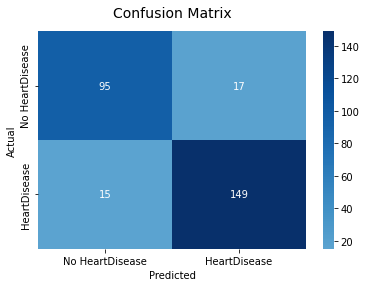

In [25]:
con_mat = confusion_matrix(y_test, best_pred_te)
fig11 = sns.heatmap(con_mat, center=True, annot=True, cmap='Blues', fmt='g')
fig11.set_title('Confusion Matrix', fontdict={'fontsize':14}, pad=14)
fig11.set_ylabel('Actual')
fig11.set_xlabel('Predicted')
fig11.xaxis.set_ticklabels(['No HeartDisease', 'HeartDisease'])
fig11.yaxis.set_ticklabels(['No HeartDisease', 'HeartDisease'])
plt.show()

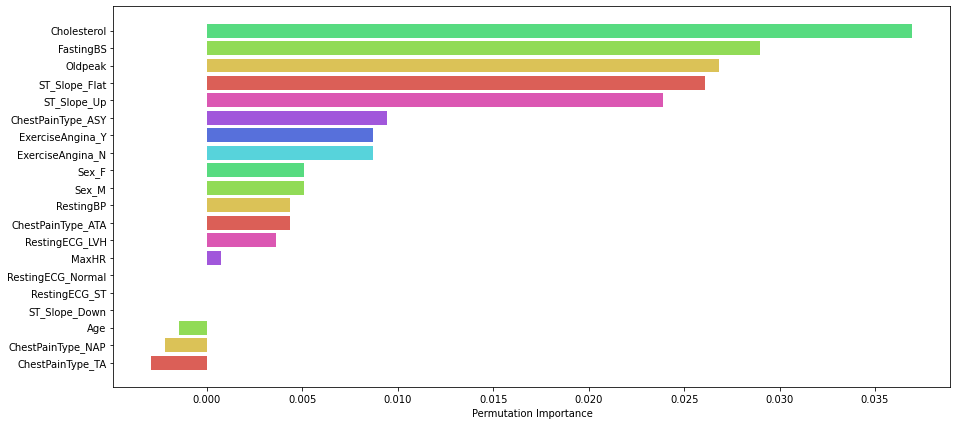

In [26]:
perm_importance = permutation_importance(best_sv, X_test, y_test, random_state=42)
features = np.array(X_test.columns)
sorted_idx = perm_importance.importances_mean.argsort()
fig12 = plt.figure(figsize=(15,7))
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx], color=sns.color_palette('hls',8))
plt.xlabel('Permutation Importance')
plt.show()